In [0]:
!pip install -q keras
import keras

In [0]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

# Definition of functions to generate trajectories by Cholesky decomposition, and for use in the least square estimation

In [0]:
import scipy.special as special

def rBergomi_path_chol(grid_points, M, H, T):
    # this function genrates M trajectories of the process Z in the rBergomi model.
    # source: https://github.com/amuguruza/RoughFCLT/blob/master/rDonsker.ipynb
    """
    @grid_points: # points in the simulation grid
    @H: Hurst Index
    @T: time horizon
    @M: # paths to simulate
    """
    
    assert 0<H<1.0
    
    ## Step1: create partition 
    
    X=np.linspace(0, 1, num=grid_points)
    
    # get rid of starting point
    X=X[1:grid_points]
    
    ## Step 2: compute covariance matrix
    Sigma=np.zeros((grid_points-1,grid_points-1))
    for j in range(grid_points-1):
        for i in range(grid_points-1):
            if i==j:
                Sigma[i,j]=np.power(X[i],2*H)/2/H
            else:
                s=np.minimum(X[i],X[j])
                t=np.maximum(X[i],X[j])
                Sigma[i,j]=np.power(t-s,H-0.5)/(H+0.5)*np.power(s,0.5+H)*special.hyp2f1(0.5-H, 0.5+H, 1.5+H, -s/(t-s))
        
    ## Step 3: compute Cholesky decomposition
    
    P=np.linalg.cholesky(Sigma)
    
    ## Step 4: draw Gaussian rv
    np.random.seed(0)
    Z=np.random.normal(loc=0.0, scale=1.0, size=[M,grid_points-1])
    
    ## Step 5: get V
    
    W=np.zeros((M,grid_points))
    for i in range(M):
        W[i,1:grid_points]=np.dot(P,Z[i,:])
        
    #Use self-similarity to extend to [0,T] 
    
    return W*np.power(T,H)

def randomisedPaths(numPaths):
    # this function generates numPaths trajectories of the Z process in the rBergomi model, with 
    # eta~Uniform(0,3) and H~Beta(1,9) for each path.
    np.random.seed(0)
    etaVec=np.random.uniform(0,3,numPaths)
    Hvec=np.random.beta(1,9,numPaths)
    res=np.zeros((numPaths,100))
    for i in range(numPaths):
        H=Hvec[i]
        res[i,:]=etaVec[i]*rBergomi_path_chol(100, 1, H, 1)
    return res, Hvec, etaVec

def lagged_mean(prices,q, lag ):
    ## takes mean of (vector entry minus its shifted entry)^q
    return np.mean( pow(np.abs(prices- prices.shift(lag)), q) )

def findH(volSeries):
    # this function estimates H using the least squares approach
    K_q=[]
    qVec=[.5, 1., 1.5, 2., 3.]
    logVec=np.log(range(1,31))
    for q in qVec:
        meanVec=[]
        for n in range(1,31):
            vn=lagged_mean(volSeries,q,n)
            meanVec.append(vn)
        meanlogVec=np.log(meanVec)
        res=np.polyfit(logVec,meanlogVec,1)
        K_q.append(res[0])
    res=np.polyfit(qVec,K_q,1)
    return(res[0])


In [0]:
def choleskyPaths(T, numStep, H, randomSeed):
    tt = np.linspace(0., T, numStep)[1:]
    covMatrixFrac = np.matrix([[fBmCov(tt[i], tt[j], H) for j in range(numStep-1)] for i in range(numStep-1)])
    cholMatFrac = np.linalg.cholesky(covMatrixFrac)
    np.random.seed(randomSeed)
    gaussianVec = np.matrix([np.random.normal(0., 1., numStep-1)])
    pathFrac = cholMatFrac * gaussianVec.T
    return pathFrac
    
def fBmCov(t, s, H): ## covariance function between t and s
    return  0.5*( np.abs(t)**H + np.abs(s)**H - np.abs(t-s)**H )
 
def fBmPaths(T,numStep, numPath,H):
    W = np.zeros((numPath,numStep))
    for i in range(numPath):
        W[i,1:numStep]=np.asarray(choleskyPaths(T, numStep, H, i)).reshape(numStep-1,)
    return W  

# Discrete H

In [0]:
T=1
numGridpoints=500
M=5000 #numPaths
Hs = [.1, .2, .3, .4, .5] 
Data=pd.DataFrame()

for H in Hs:
    path=rBergomi_path_chol(numGridpoints, M, H , T)
    dF=pd.DataFrame(path)
    dF['label']=H
    Data=pd.concat([Data,dF])

Data=Data.sample(frac=1) #this randomly re-orders robustData
DataVal=Data.values

from sklearn.model_selection import train_test_split

xValues=DataVal[:,:500]
yValues=DataVal[:,-1]
# split up the data
xTraining, xTest, yTraining, yTest = train_test_split(xValues, yValues , test_size=0.3)
xTrain, xValid, yTrain, yValid = train_test_split(xTraining, yTraining , test_size=0.2)
# reshape
xTrain=xTrain.reshape(xTrain.shape[0], 500,1)
xValid=xValid.reshape(xValid.shape[0], 500,1)
xTest=xTest.reshape(xTest.shape[0], 500,1)
yTrain=yTrain.reshape(yTrain.shape[0], 1)
yValid=yValid.reshape(yValid.shape[0], 1)
yTest=yTest.reshape(yTest.shape[0], 1)

7500/7500 [==============================] - 1s 124us/step


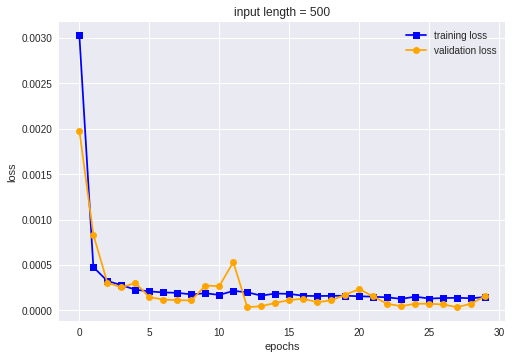

7500/7500 [==============================] - 1s 124us/step


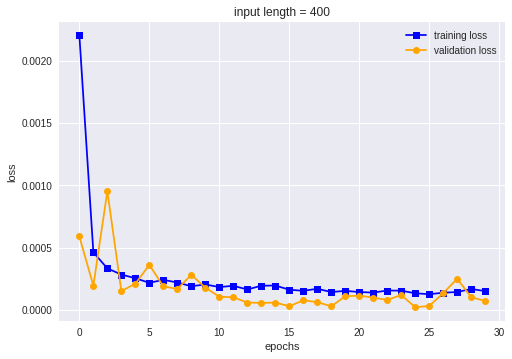

7500/7500 [==============================] - 1s 105us/step


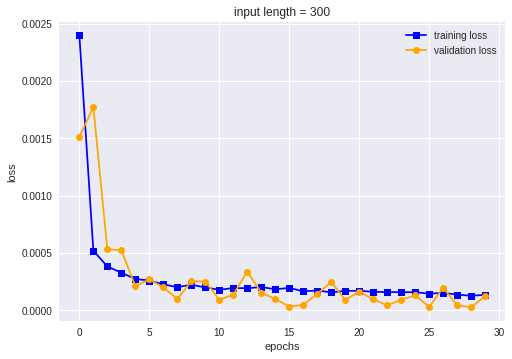

7500/7500 [==============================] - 1s 100us/step


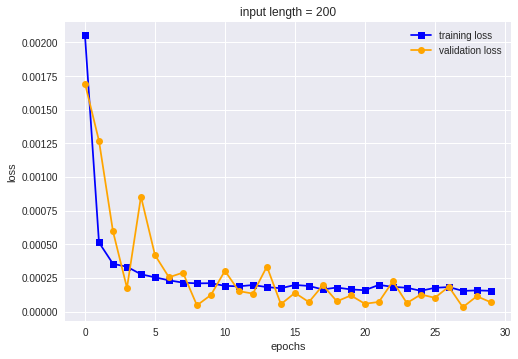

7500/7500 [==============================] - 1s 102us/step


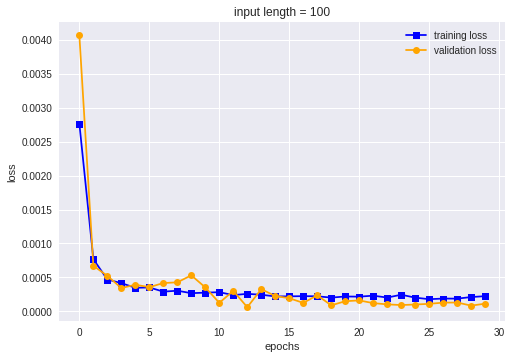

[[93.75558280944824, 0.9323344230651855], [92.02112913131714, 0.9339020252227783], [80.9203131198883, 0.7856433391571045], [74.88963770866394, 0.7526910305023193], [69.77445816993713, 0.7639431953430176]] [0.0123221087071068, 0.008263060205200661, 0.01095666561491289, 0.0081958009299213, 0.010407375695485464] [627.6161942481995, 634.2210648059845, 635.6453096866608, 622.003889799118, 591.7569875717163] [0.20100354234309004, 0.2013895373781464, 0.2025108494587938, 0.20461960104540403, 0.21184291781062936]


In [0]:
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from sklearn.metrics import classification_report
import time

batchSize=64
kSize=20
poolSize=3

lossVector=[] # gives test RMSE for the CNN
timeVector=[] # gives time taken for training and testing of the CNN respectively
LSloss=[] # gives RMSE for the least squares approach
LStime=[] # gives time taken to execute the least squares approach
timeSteps=[500,400,300,200,100]
for t in timeSteps:
    T=time.time()
    classifyH = Sequential()
    classifyH.add(Conv1D(32, kernel_size=kSize ,activation='linear',padding='same',input_shape=(t,1)))
    classifyH.add(LeakyReLU(alpha=0.1))
    classifyH.add(MaxPooling1D(pool_size=poolSize,padding='same'))
    classifyH.add(Dropout(0.25))
    classifyH.add(Conv1D(64, kSize, activation='linear',padding='same'))
    classifyH.add(LeakyReLU(alpha=0.3))
    classifyH.add(MaxPooling1D(pool_size=poolSize,padding='same'))
    classifyH.add(Dropout(0.25))
    classifyH.add(Conv1D(128, kSize, activation='linear',padding='same'))
    classifyH.add(LeakyReLU(alpha=0.1))                  
    classifyH.add(MaxPooling1D(pool_size=poolSize,padding='same'))
    classifyH.add(Dropout(0.4))
    classifyH.add(Flatten())
    classifyH.add(Dense(128, activation='linear'))
    classifyH.add(LeakyReLU(alpha=0.1))           
    classifyH.add(Dropout(0.3))
    classifyH.add(Dense(1, activation='sigmoid'))
    classifyH.compile(loss=keras.losses.mean_squared_error, optimizer='Adam')    
    xTrain=xTrain[:,:t]
    xValid=xValid[:,:t]
    xTest=xTest[:,:t]
    trainH=classifyH.fit(xTrain,yTrain,batch_size=batchSize,epochs=30,verbose=0,validation_data=(xValid,yValid))
    t1=time.time()-T    
    T=time.time()
    test=classifyH.evaluate(xTest,yTest)
    timeVector.append([t1, time.time()-T])
    lossVector.append(np.sqrt(test))
    loss=trainH.history['loss']
    valLoss=trainH.history['val_loss']
    epochVec=range(len(loss))
    plt.plot(epochVec, loss, color='blue', marker='s', label='training loss')
    plt.plot(epochVec, valLoss, color='orange', marker='o', label='validation loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('input length = %s'%t)
    plt.legend(loc=1)
    plt.show()
    
    # now we execute the least squares estimation of H
    Hvec1=[]
    T=time.time()
    for I in range(xTest.shape[0]):
        volSeries=xTest[I]
        volSeries=volSeries.reshape(t)
        volSeries=pd.Series(volSeries)
        Hvec1.append(findH(volSeries))
    LStime.append(time.time()-T)
    LSloss.append(np.sqrt(np.mean(np.power(Hvec1-yTest,2))))   

print(timeVector, lossVector, LStime, LSloss) # these values are those found in Tables 2. 


## Using the trained CNN to calibrate H from volatility data from Oxford-Man dataset

In [0]:
volData=pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vRLxqxFoQ1Hen4jQ0ehb6_3YXRkzKJpmPvrW4jR7SQbXAlvogHi2Fcyfyx9gUqnqPu6zWT5BeOhUXeR/pub?output=csv')
volData=volData.drop(columns=['close_time','open_price'])
Symbol=np.unique(volData.Symbol)
methodList=volData.columns[2:]


for s in Symbol:
    data=volData[volData.Symbol==s].iloc[0:200]
    for meth in methodList:
        sample=data[meth]
        ind=0
        diffVec=[]
        for t in [1,2,3,4,5,6,7,8,9,10]:
            volSeries=sample.iloc[ind:(100+ind)].values
            # NEED TO TAKE LOGS OF VOLS
            volSeries=np.log(volSeries)
            volSeries=volSeries.reshape(1,100,1)
            cnnPred=classifyH.predict(volSeries)
            volSeries=sample.iloc[ind:(100+ind)]
            volSeries=np.log(volSeries)
            lssPred=findH(volSeries)
            diffVec.append(np.square(cnnPred-lssPred))
            ind=10*t
            
print(np.sqrt(np.mean(diffVec)), np.std(diffVec))
# np.sqrt(np.mean(diffVec) gives RMSE, np.std(diffVec) gives the standard deviation in Table 9

0.05558049 0.0029000917


# Uniform H

In [0]:
T=1
numGridpoints=500
M=5000 #numPaths
np.random.seed(195)
Hs=np.random.uniform(0.0,0.5,5)
Data=pd.DataFrame()

for H in Hs:
    path=rBergomi_path_chol(numGridpoints, M, H , T)
    dF=pd.DataFrame(path)
    dF['label']=H
    Data=pd.concat([Data,dF])

Data=Data.sample(frac=1) #this randomly re-orders robustData
DataVal=Data.values

from sklearn.model_selection import train_test_split

xValues=DataVal[:,:500]
yValues=DataVal[:,-1]
# split up the data
xTraining, xTest, yTraining, yTest = train_test_split(xValues, yValues , test_size=0.3)
xTrain, xValid, yTrain, yValid = train_test_split(xTraining, yTraining , test_size=0.2)
# reshape
xTrain=xTrain.reshape(xTrain.shape[0], 500,1)
xValid=xValid.reshape(xValid.shape[0], 500,1)
xTest=xTest.reshape(xTest.shape[0], 500,1)
yTrain=yTrain.reshape(yTrain.shape[0], 1)
yValid=yValid.reshape(yValid.shape[0], 1)
yTest=yTest.reshape(yTest.shape[0], 1)

7500/7500 [==============================] - 1s 124us/step


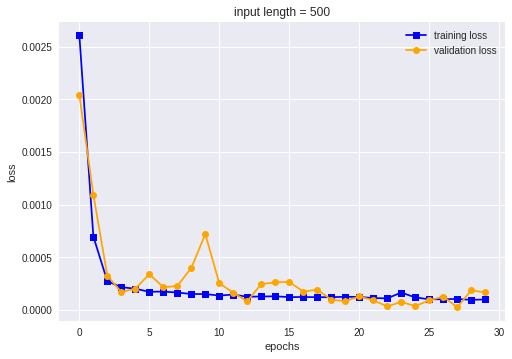

7500/7500 [==============================] - 1s 109us/step


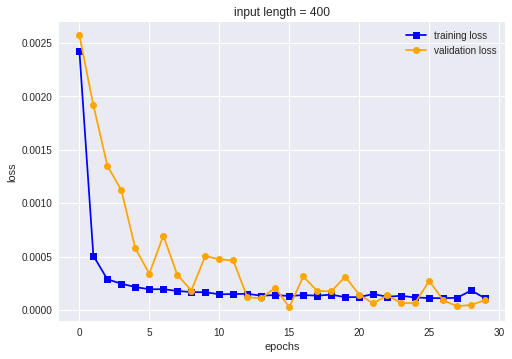

7500/7500 [==============================] - 1s 104us/step


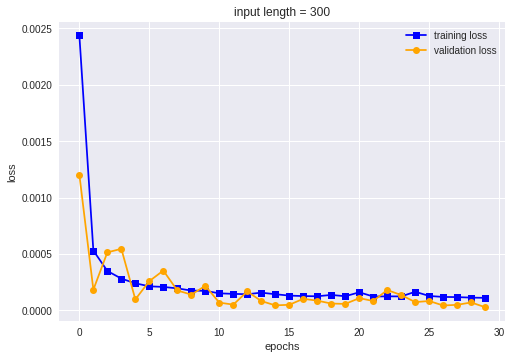

7500/7500 [==============================] - 1s 98us/step


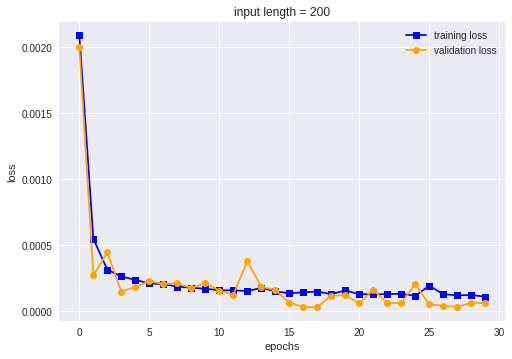

7500/7500 [==============================] - 1s 91us/step


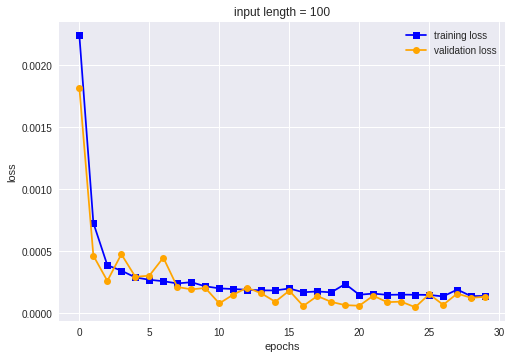

[[96.78945970535278, 0.9342403411865234], [86.3464183807373, 0.8197026252746582], [79.80344414710999, 0.7801802158355713], [72.19852614402771, 0.7333521842956543], [66.65740871429443, 0.6807291507720947]] [0.012821363902731295, 0.009408686989576441, 0.005115037214655385, 0.007910352245427143, 0.011368587299388808] [628.2575633525848, 634.2414536476135, 630.748916387558, 620.720504283905, 611.6080341339111] [0.18924290191704654, 0.18951629226408834, 0.19069818997730464, 0.1926911742303019, 0.19887179935168126]


In [0]:
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from sklearn.metrics import classification_report
import time

batchSize=64
kSize=20
poolSize=3

lossVector=[] # gives test RMSE for the CNN
timeVector=[] # gives time taken for training and testing of the CNN respectively
LSloss=[] # gives RMSE for the least squares approach
LStime=[] # gives time taken to execute the least squares approach
timeSteps=[500,400,300,200,100]
for t in timeSteps:
    T=time.time()
    classifyH = Sequential()
    classifyH.add(Conv1D(32, kernel_size=kSize ,activation='linear',padding='same',input_shape=(t,1)))
    classifyH.add(LeakyReLU(alpha=0.1))
    classifyH.add(MaxPooling1D(pool_size=poolSize,padding='same'))
    classifyH.add(Dropout(0.25))
    classifyH.add(Conv1D(64, kSize, activation='linear',padding='same'))
    classifyH.add(LeakyReLU(alpha=0.3))
    classifyH.add(MaxPooling1D(pool_size=poolSize,padding='same'))
    classifyH.add(Dropout(0.25))
    classifyH.add(Conv1D(128, kSize, activation='linear',padding='same'))
    classifyH.add(LeakyReLU(alpha=0.1))                  
    classifyH.add(MaxPooling1D(pool_size=poolSize,padding='same'))
    classifyH.add(Dropout(0.4))
    classifyH.add(Flatten())
    classifyH.add(Dense(128, activation='linear'))
    classifyH.add(LeakyReLU(alpha=0.1))           
    classifyH.add(Dropout(0.3))
    classifyH.add(Dense(1, activation='sigmoid'))
    classifyH.compile(loss=keras.losses.mean_squared_error, optimizer='Adam')    
    xTrain=xTrain[:,:t]
    xValid=xValid[:,:t]
    xTest=xTest[:,:t]
    trainH=classifyH.fit(xTrain,yTrain,batch_size=batchSize,epochs=30,verbose=0,validation_data=(xValid,yValid))
    t1=time.time()-T    
    T=time.time()
    test=classifyH.evaluate(xTest,yTest)
    timeVector.append([t1, time.time()-T])
    lossVector.append(np.sqrt(test))
    loss=trainH.history['loss']
    valLoss=trainH.history['val_loss']
    epochVec=range(len(loss))
    plt.plot(epochVec, loss, color='blue', marker='s', label='training loss')
    plt.plot(epochVec, valLoss, color='orange', marker='o', label='validation loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('input length = %s'%t)
    plt.legend(loc=1)
    plt.show()
    
    # now we execute the least squares estimation of H
    Hvec1=[]
    T=time.time()
    for I in range(xTest.shape[0]):
        volSeries=xTest[I]
        volSeries=volSeries.reshape(t)
        volSeries=pd.Series(volSeries)
        Hvec1.append(findH(volSeries))
    LStime.append(time.time()-T)
    LSloss.append(np.sqrt(np.mean(np.power(Hvec1-yTest,2))))    

print(timeVector, lossVector, LStime, LSloss) # these values are those found in Tables 3. 


## Using the trained CNN to calibrate H from volatility data from Oxford-Man dataset

In [0]:
volData=pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vRLxqxFoQ1Hen4jQ0ehb6_3YXRkzKJpmPvrW4jR7SQbXAlvogHi2Fcyfyx9gUqnqPu6zWT5BeOhUXeR/pub?output=csv')
volData=volData.drop(columns=['close_time','open_price'])
Symbol=np.unique(volData.Symbol)
methodList=volData.columns[2:]


for s in Symbol:
    data=volData[volData.Symbol==s].iloc[0:200]
    for meth in methodList:
        sample=data[meth]
        ind=0
        diffVec=[]
        for t in [1,2,3,4,5,6,7,8,9,10]:
            volSeries=sample.iloc[ind:(100+ind)].values
            # NEED TO TAKE LOGS OF VOLS
            volSeries=np.log(volSeries)
            volSeries=volSeries.reshape(1,100,1)
            cnnPred=classifyH.predict(volSeries)
            volSeries=sample.iloc[ind:(100+ind)]
            volSeries=np.log(volSeries)
            lssPred=findH(volSeries)
            diffVec.append(np.square(cnnPred-lssPred))
            ind=10*t
            
print(np.sqrt(np.mean(diffVec)), np.std(diffVec))
# np.sqrt(np.mean(diffVec) gives RMSE, np.std(diffVec) gives the standard deviation in Table 9

0.2443176 0.011407781


# Beta distributed H

In [0]:

T=1
numGridpoints=500
M=5000 #numPaths
np.random.seed(195)
Hs= np.random.beta(1.,9.,5)
Data=pd.DataFrame()

for H in Hs:
    path=rBergomi_path_chol(numGridpoints, M, H , T)
    dF=pd.DataFrame(path)
    dF['label']=H
    Data=pd.concat([Data,dF])

Data=Data.sample(frac=1) #this randomly re-orders robustData
DataVal=Data.values

from sklearn.model_selection import train_test_split

xValues=DataVal[:,:500]
yValues=DataVal[:,-1]
# split up the data
xTraining, xTest, yTraining, yTest = train_test_split(xValues, yValues , test_size=0.3)
xTrain, xValid, yTrain, yValid = train_test_split(xTraining, yTraining , test_size=0.2)
# reshape
xTrain=xTrain.reshape(xTrain.shape[0], 500,1)
xValid=xValid.reshape(xValid.shape[0], 500,1)
xTest=xTest.reshape(xTest.shape[0], 500,1)
yTrain=yTrain.reshape(yTrain.shape[0], 1)
yValid=yValid.reshape(yValid.shape[0], 1)
yTest=yTest.reshape(yTest.shape[0], 1)

7500/7500 [==============================] - 1s 102us/step


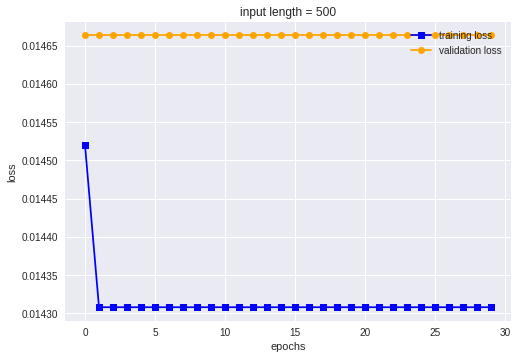

7500/7500 [==============================] - 1s 100us/step


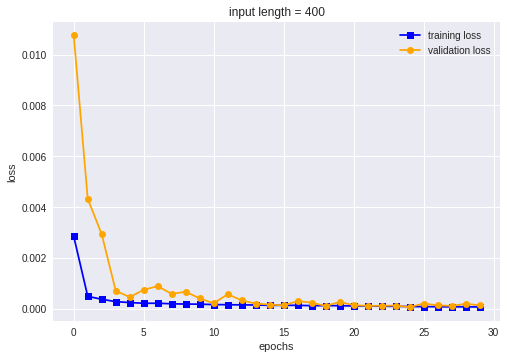

7500/7500 [==============================] - 1s 98us/step


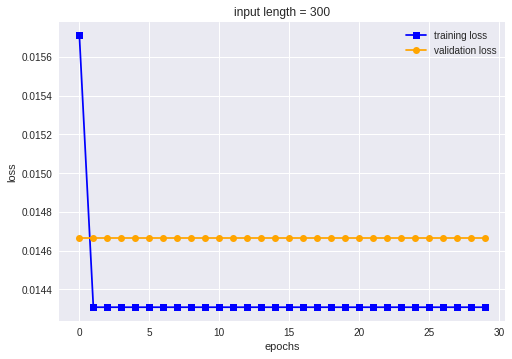

7500/7500 [==============================] - 1s 93us/step


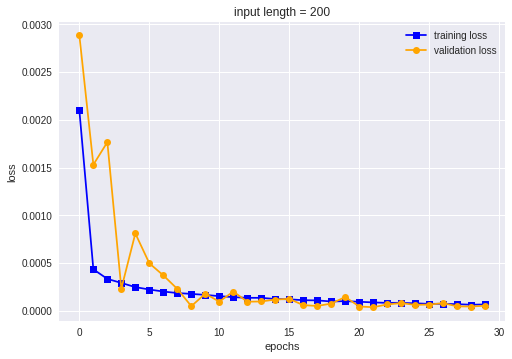

7500/7500 [==============================] - 1s 95us/step


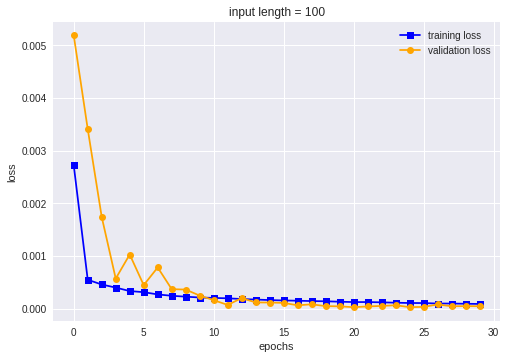

[[94.20405316352844, 0.7673356533050537], [87.0931305885315, 0.7494621276855469], [80.62876915931702, 0.7384934425354004], [73.26497960090637, 0.69624924659729], [70.70950388908386, 0.7170031070709229]] [0.12068770946179623, 0.011715920050640247, 0.12068770946179623, 0.007192874671311793, 0.006671839777086592] [644.6011419296265, 637.3347728252411, 637.4485559463501, 626.7724640369415, 616.7373924255371] [0.09662643986666676, 0.09698515486140646, 0.0979050406308694, 0.09962379942827349, 0.10400923773110297]


In [0]:
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from sklearn.metrics import classification_report
import time

batchSize=64
kSize=20
poolSize=3

lossVector=[] # gives test RMSE for the CNN
timeVector=[] # gives time taken for training and testing of the CNN respectively
LSloss=[] # gives RMSE for the least squares approach
LStime=[] # gives time taken to execute the least squares approach
timeSteps=[500,400,300,200,100]
for t in timeSteps:
    T=time.time()
    classifyH = Sequential()
    classifyH.add(Conv1D(32, kernel_size=kSize ,activation='linear',padding='same',input_shape=(t,1)))
    classifyH.add(LeakyReLU(alpha=0.1))
    classifyH.add(MaxPooling1D(pool_size=poolSize,padding='same'))
    classifyH.add(Dropout(0.25))
    classifyH.add(Conv1D(64, kSize, activation='linear',padding='same'))
    classifyH.add(LeakyReLU(alpha=0.3))
    classifyH.add(MaxPooling1D(pool_size=poolSize,padding='same'))
    classifyH.add(Dropout(0.25))
    classifyH.add(Conv1D(128, kSize, activation='linear',padding='same'))
    classifyH.add(LeakyReLU(alpha=0.1))                  
    classifyH.add(MaxPooling1D(pool_size=poolSize,padding='same'))
    classifyH.add(Dropout(0.4))
    classifyH.add(Flatten())
    classifyH.add(Dense(128, activation='linear'))
    classifyH.add(LeakyReLU(alpha=0.1))           
    classifyH.add(Dropout(0.3))
    classifyH.add(Dense(1, activation='sigmoid'))
    classifyH.compile(loss=keras.losses.mean_squared_error, optimizer='Adam')    
    xTrain=xTrain[:,:t]
    xValid=xValid[:,:t]
    xTest=xTest[:,:t]
    trainH=classifyH.fit(xTrain,yTrain,batch_size=batchSize,epochs=30,verbose=0,validation_data=(xValid,yValid))
    t1=time.time()-T    
    T=time.time()
    test=classifyH.evaluate(xTest,yTest)
    timeVector.append([t1, time.time()-T])
    lossVector.append(np.sqrt(test))
    loss=trainH.history['loss']
    valLoss=trainH.history['val_loss']
    epochVec=range(len(loss))
    plt.plot(epochVec, loss, color='blue', marker='s', label='training loss')
    plt.plot(epochVec, valLoss, color='orange', marker='o', label='validation loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('input length = %s'%t)
    plt.legend(loc=1)
    plt.show()
    
    # now we execute the least squares estimation of H
    Hvec1=[]
    T=time.time()
    for I in range(xTest.shape[0]):
        volSeries=xTest[I]
        volSeries=volSeries.reshape(t)
        volSeries=pd.Series(volSeries)
        Hvec1.append(findH(volSeries))
    LStime.append(time.time()-T)
    LSloss.append(np.sqrt(np.mean(np.power(Hvec1-yTest,2))))    

print(timeVector, lossVector, LStime, LSloss) # these values are those found in Tables 4. 


## Using the trained CNN to calibrate H from volatility data from Oxford-Man dataset

In [0]:
volData=pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vRLxqxFoQ1Hen4jQ0ehb6_3YXRkzKJpmPvrW4jR7SQbXAlvogHi2Fcyfyx9gUqnqPu6zWT5BeOhUXeR/pub?output=csv')
volData=volData.drop(columns=['close_time','open_price'])
Symbol=np.unique(volData.Symbol)
methodList=volData.columns[2:]


for s in Symbol:
    data=volData[volData.Symbol==s].iloc[0:200]
    for meth in methodList:
        sample=data[meth]
        ind=0
        diffVec=[]
        for t in [1,2,3,4,5,6,7,8,9,10]:
            volSeries=sample.iloc[ind:(100+ind)].values
            # NEED TO TAKE LOGS OF VOLS
            volSeries=np.log(volSeries)
            volSeries=volSeries.reshape(1,100,1)
            cnnPred=classifyH.predict(volSeries)
            volSeries=sample.iloc[ind:(100+ind)]
            volSeries=np.log(volSeries)
            lssPred=findH(volSeries)
            diffVec.append(np.square(cnnPred-lssPred))
            ind=10*t
            
print(np.sqrt(np.mean(diffVec)), np.std(diffVec))
# np.sqrt(np.mean(diffVec) gives RMSE, np.std(diffVec) gives the standard deviation in Table 9

0.042529527 0.0010982228


# Robustness test: discrete H, $\eta$ = 0.25

In [0]:


T=1
numGridpoints=100
M=5000 #numPaths
Hs = [.1, .2, .3, .4, .5] 
Data=pd.DataFrame()
eta=0.25

for H in Hs:
    path=eta*rBergomi_path_chol(numGridpoints, M, H , T)
    dF=pd.DataFrame(path)
    dF['label']=H
    Data=pd.concat([Data,dF])

Data=Data.sample(frac=1) #this randomly re-orders robustData
DataVal=Data.values

from sklearn.model_selection import train_test_split

xValues=DataVal[:,:100]
yValues=DataVal[:,-1]
# split up the data
xTraining, xTest, yTraining, yTest = train_test_split(xValues, yValues , test_size=0.3)
xTrain, xValid, yTrain, yValid = train_test_split(xTraining, yTraining , test_size=0.2)
# reshape
xTrain=xTrain.reshape(xTrain.shape[0], 100,1)
xValid=xValid.reshape(xValid.shape[0], 100,1)
xTest=xTest.reshape(xTest.shape[0], 100,1)
yTrain=yTrain.reshape(yTrain.shape[0], 1)
yValid=yValid.reshape(yValid.shape[0], 1)
yTest=yTest.reshape(yTest.shape[0], 1)

7500/7500 [==============================] - 1s 84us/step


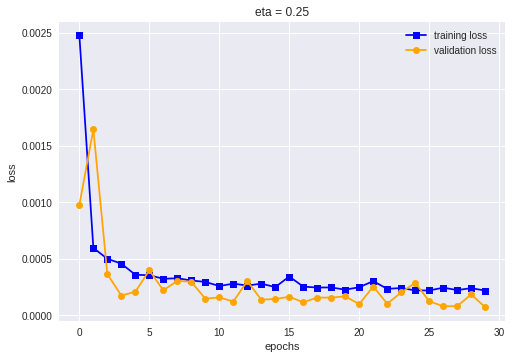

[[66.81315851211548, 0.6281251907348633]] [0.008206285027860437] [666.7905626296997] [0.2121805968884585]


In [0]:
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from sklearn.metrics import classification_report
import time
import matplotlib.pyplot as plt

batchSize=64
kSize=20
poolSize=3

lossVector=[] # gives test RMSE for the CNN
timeVector=[] # gives time taken for training and testing of the CNN respectively
LSloss=[] # gives RMSE for the least squares approach
LStime=[] # gives time taken to execute the least squares approach
classifyH = Sequential()
classifyH.add(Conv1D(32, kernel_size=kSize ,activation='linear',padding='same',input_shape=(100,1)))
classifyH.add(LeakyReLU(alpha=0.1))
classifyH.add(MaxPooling1D(pool_size=poolSize,padding='same'))
classifyH.add(Dropout(0.25))
classifyH.add(Conv1D(64, kSize, activation='linear',padding='same'))
classifyH.add(LeakyReLU(alpha=0.3))
classifyH.add(MaxPooling1D(pool_size=poolSize,padding='same'))
classifyH.add(Dropout(0.25))
classifyH.add(Conv1D(128, kSize, activation='linear',padding='same'))
classifyH.add(LeakyReLU(alpha=0.1))                  
classifyH.add(MaxPooling1D(pool_size=poolSize,padding='same'))
classifyH.add(Dropout(0.4))
classifyH.add(Flatten())
classifyH.add(Dense(128, activation='linear'))
classifyH.add(LeakyReLU(alpha=0.1))           
classifyH.add(Dropout(0.3))
classifyH.add(Dense(1, activation='sigmoid'))
classifyH.compile(loss=keras.losses.mean_squared_error, optimizer='Adam')    
T=time.time()
trainH=classifyH.fit(xTrain,yTrain,batch_size=batchSize,epochs=30,verbose=0,validation_data=(xValid,yValid))
t1=time.time()-T    
T=time.time()
test=classifyH.evaluate(xTest,yTest)
timeVector.append([t1, time.time()-T])
lossVector.append(np.sqrt(test))
loss=trainH.history['loss']
valLoss=trainH.history['val_loss']
epochVec=range(len(loss))
plt.plot(epochVec, loss, color='blue', marker='s', label='training loss')
plt.plot(epochVec, valLoss, color='orange', marker='o', label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)
plt.title('eta = %s'%eta)
plt.show()
 
Hvec1=[]
T=time.time()
# for loop below excutes the least squares estimation of H
for I in range(xTest.shape[0]):
    volSeries=xTest[I]
    volSeries=volSeries.reshape(100)
    volSeries=pd.Series(volSeries)
    Hvec1.append(findH(volSeries))
LStime.append(time.time()-T)
LSloss.append(np.sqrt(np.mean(np.power(Hvec1-yTest,2)))) # here we compute the RMSE for the least squares approach  
  
print(timeVector, lossVector, LStime, LSloss) # these values are those found in Table 5 

# Robustness test: discrete H, $\eta$ = 0.8



In [0]:


T=1
numGridpoints=100
M=5000 #numPaths
Hs = [.1, .2, .3, .4, .5] 
Data=pd.DataFrame()
eta=0.8

for H in Hs:
    path=eta*rBergomi_path_chol(numGridpoints, M, H , T)
    dF=pd.DataFrame(path)
    dF['label']=H
    Data=pd.concat([Data,dF])

Data=Data.sample(frac=1) #this randomly re-orders robustData
DataVal=Data.values

from sklearn.model_selection import train_test_split

xValues=DataVal[:,:100]
yValues=DataVal[:,-1]
# split up the data
xTraining, xTest, yTraining, yTest = train_test_split(xValues, yValues , test_size=0.3)
xTrain, xValid, yTrain, yValid = train_test_split(xTraining, yTraining , test_size=0.2)
# reshape
xTrain=xTrain.reshape(xTrain.shape[0], 100,1)
xValid=xValid.reshape(xValid.shape[0], 100,1)
xTest=xTest.reshape(xTest.shape[0], 100,1)
yTrain=yTrain.reshape(yTrain.shape[0], 1)
yValid=yValid.reshape(yValid.shape[0], 1)
yTest=yTest.reshape(yTest.shape[0], 1)

7500/7500 [==============================] - 1s 80us/step


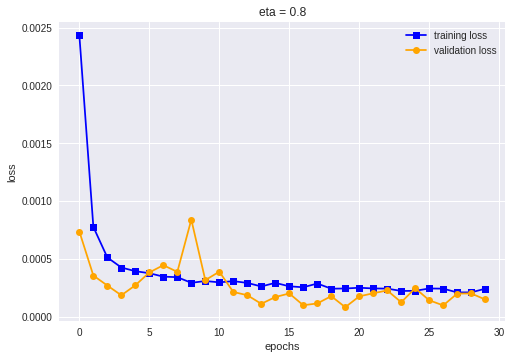

[[66.92626667022705, 0.6012797355651855]] [0.01136593403704127] [665.6835293769836] [0.2121805968884585]


In [0]:
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from sklearn.metrics import classification_report
import time
import matplotlib.pyplot as plt

batchSize=64
kSize=20
poolSize=3

lossVector=[] # gives test RMSE for the CNN
timeVector=[] # gives time taken for training and testing of the CNN respectively
LSloss=[] # gives RMSE for the least squares approach
LStime=[] # gives time taken to execute the least squares approach
classifyH = Sequential()
classifyH.add(Conv1D(32, kernel_size=kSize ,activation='linear',padding='same',input_shape=(100,1)))
classifyH.add(LeakyReLU(alpha=0.1))
classifyH.add(MaxPooling1D(pool_size=poolSize,padding='same'))
classifyH.add(Dropout(0.25))
classifyH.add(Conv1D(64, kSize, activation='linear',padding='same'))
classifyH.add(LeakyReLU(alpha=0.3))
classifyH.add(MaxPooling1D(pool_size=poolSize,padding='same'))
classifyH.add(Dropout(0.25))
classifyH.add(Conv1D(128, kSize, activation='linear',padding='same'))
classifyH.add(LeakyReLU(alpha=0.1))                  
classifyH.add(MaxPooling1D(pool_size=poolSize,padding='same'))
classifyH.add(Dropout(0.4))
classifyH.add(Flatten())
classifyH.add(Dense(128, activation='linear'))
classifyH.add(LeakyReLU(alpha=0.1))           
classifyH.add(Dropout(0.3))
classifyH.add(Dense(1, activation='sigmoid'))
classifyH.compile(loss=keras.losses.mean_squared_error, optimizer='Adam')    
T=time.time()
trainH=classifyH.fit(xTrain,yTrain,batch_size=batchSize,epochs=30,verbose=0,validation_data=(xValid,yValid))
t1=time.time()-T    
T=time.time()
test=classifyH.evaluate(xTest,yTest)
timeVector.append([t1, time.time()-T])
lossVector.append(np.sqrt(test))
loss=trainH.history['loss']
valLoss=trainH.history['val_loss']
epochVec=range(len(loss))
plt.plot(epochVec, loss, color='blue', marker='s', label='training loss')
plt.plot(epochVec, valLoss, color='orange', marker='o', label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)
plt.title('eta = %s'%eta)
plt.show()
 
Hvec1=[]
T=time.time()
# for loop below excutes the least squares estimation of H
for I in range(xTest.shape[0]):
    volSeries=xTest[I]
    volSeries=volSeries.reshape(100)
    volSeries=pd.Series(volSeries)
    Hvec1.append(findH(volSeries))
LStime.append(time.time()-T)
LSloss.append(np.sqrt(np.mean(np.power(Hvec1-yTest,2)))) # here we compute the RMSE for the least squares approach  
  
print(timeVector, lossVector, LStime, LSloss) # these values are those found in Table 5 

# Robustness test: discrete H, $\eta$ = 1.3

In [0]:
T=1
numGridpoints=100
M=5000 #numPaths
Hs = [.1, .2, .3, .4, .5] 
Data=pd.DataFrame()
eta=1.3

for H in Hs:
    path=eta*rBergomi_path_chol(numGridpoints, M, H , T)
    dF=pd.DataFrame(path)
    dF['label']=H
    Data=pd.concat([Data,dF])

Data=Data.sample(frac=1) #this randomly re-orders robustData
DataVal=Data.values

from sklearn.model_selection import train_test_split

xValues=DataVal[:,:100]
yValues=DataVal[:,-1]
# split up the data
xTraining, xTest, yTraining, yTest = train_test_split(xValues, yValues , test_size=0.3)
xTrain, xValid, yTrain, yValid = train_test_split(xTraining, yTraining , test_size=0.2)
# reshape
xTrain=xTrain.reshape(xTrain.shape[0], 100,1)
xValid=xValid.reshape(xValid.shape[0], 100,1)
xTest=xTest.reshape(xTest.shape[0], 100,1)
yTrain=yTrain.reshape(yTrain.shape[0], 1)
yValid=yValid.reshape(yValid.shape[0], 1)
yTest=yTest.reshape(yTest.shape[0], 1)

7500/7500 [==============================] - 1s 87us/step


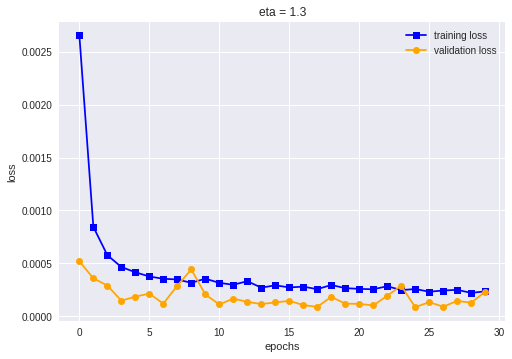

[[67.21789336204529, 0.6564037799835205]] [0.014734628137498287] [671.1133432388306] [0.21218059688845853]


In [0]:
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from sklearn.metrics import classification_report
import time
import matplotlib.pyplot as plt

batchSize=64
kSize=20
poolSize=3

lossVector=[] # gives test RMSE for the CNN
timeVector=[] # gives time taken for training and testing of the CNN respectively
LSloss=[] # gives RMSE for the least squares approach
LStime=[] # gives time taken to execute the least squares approach
classifyH = Sequential()
classifyH.add(Conv1D(32, kernel_size=kSize ,activation='linear',padding='same',input_shape=(100,1)))
classifyH.add(LeakyReLU(alpha=0.1))
classifyH.add(MaxPooling1D(pool_size=poolSize,padding='same'))
classifyH.add(Dropout(0.25))
classifyH.add(Conv1D(64, kSize, activation='linear',padding='same'))
classifyH.add(LeakyReLU(alpha=0.3))
classifyH.add(MaxPooling1D(pool_size=poolSize,padding='same'))
classifyH.add(Dropout(0.25))
classifyH.add(Conv1D(128, kSize, activation='linear',padding='same'))
classifyH.add(LeakyReLU(alpha=0.1))                  
classifyH.add(MaxPooling1D(pool_size=poolSize,padding='same'))
classifyH.add(Dropout(0.4))
classifyH.add(Flatten())
classifyH.add(Dense(128, activation='linear'))
classifyH.add(LeakyReLU(alpha=0.1))           
classifyH.add(Dropout(0.3))
classifyH.add(Dense(1, activation='sigmoid'))
classifyH.compile(loss=keras.losses.mean_squared_error, optimizer='Adam')    
T=time.time()
trainH=classifyH.fit(xTrain,yTrain,batch_size=batchSize,epochs=30,verbose=0,validation_data=(xValid,yValid))
t1=time.time()-T    
T=time.time()
test=classifyH.evaluate(xTest,yTest)
timeVector.append([t1, time.time()-T])
lossVector.append(np.sqrt(test))
loss=trainH.history['loss']
valLoss=trainH.history['val_loss']
epochVec=range(len(loss))
plt.plot(epochVec, loss, color='blue', marker='s', label='training loss')
plt.plot(epochVec, valLoss, color='orange', marker='o', label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)
plt.title('eta = %s'%eta)
plt.show()
 
Hvec1=[]
T=time.time()
# for loop below excutes the least squares estimation of H
for I in range(xTest.shape[0]):
    volSeries=xTest[I]
    volSeries=volSeries.reshape(100)
    volSeries=pd.Series(volSeries)
    Hvec1.append(findH(volSeries))
LStime.append(time.time()-T)
LSloss.append(np.sqrt(np.mean(np.power(Hvec1-yTest,2)))) # here we compute the RMSE for the least squares approach  
  
print(timeVector, lossVector, LStime, LSloss) # these values are those found in Table 5 

# Robustness test: discrete H, $\eta$ = 2.5

In [0]:
T=1
numGridpoints=100
M=5000 #numPaths
Hs = [.1, .2, .3, .4, .5] 
Data=pd.DataFrame()
eta=2.5

for H in Hs:
    path=eta*rBergomi_path_chol(numGridpoints, M, H , T)
    dF=pd.DataFrame(path)
    dF['label']=H
    Data=pd.concat([Data,dF])

Data=Data.sample(frac=1) #this randomly re-orders robustData
DataVal=Data.values

from sklearn.model_selection import train_test_split

xValues=DataVal[:,:100]
yValues=DataVal[:,-1]
# split up the data
xTraining, xTest, yTraining, yTest = train_test_split(xValues, yValues , test_size=0.3)
xTrain, xValid, yTrain, yValid = train_test_split(xTraining, yTraining , test_size=0.2)
# reshape
xTrain=xTrain.reshape(xTrain.shape[0], 100,1)
xValid=xValid.reshape(xValid.shape[0], 100,1)
xTest=xTest.reshape(xTest.shape[0], 100,1)
yTrain=yTrain.reshape(yTrain.shape[0], 1)
yValid=yValid.reshape(yValid.shape[0], 1)
yTest=yTest.reshape(yTest.shape[0], 1)

7500/7500 [==============================] - 1s 84us/step


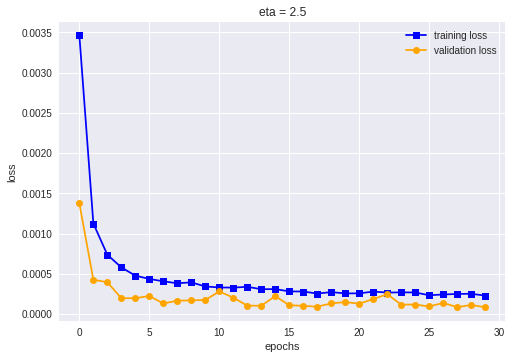

[[67.27152752876282, 0.6293554306030273]] [0.009003429649873584] [667.1621646881104] [0.21218059688845853]


In [0]:
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from sklearn.metrics import classification_report
import time
import matplotlib.pyplot as plt

batchSize=64
kSize=20
poolSize=3

lossVector=[] # gives test RMSE for the CNN
timeVector=[] # gives time taken for training and testing of the CNN respectively
LSloss=[] # gives RMSE for the least squares approach
LStime=[] # gives time taken to execute the least squares approach
classifyH = Sequential()
classifyH.add(Conv1D(32, kernel_size=kSize ,activation='linear',padding='same',input_shape=(100,1)))
classifyH.add(LeakyReLU(alpha=0.1))
classifyH.add(MaxPooling1D(pool_size=poolSize,padding='same'))
classifyH.add(Dropout(0.25))
classifyH.add(Conv1D(64, kSize, activation='linear',padding='same'))
classifyH.add(LeakyReLU(alpha=0.3))
classifyH.add(MaxPooling1D(pool_size=poolSize,padding='same'))
classifyH.add(Dropout(0.25))
classifyH.add(Conv1D(128, kSize, activation='linear',padding='same'))
classifyH.add(LeakyReLU(alpha=0.1))                  
classifyH.add(MaxPooling1D(pool_size=poolSize,padding='same'))
classifyH.add(Dropout(0.4))
classifyH.add(Flatten())
classifyH.add(Dense(128, activation='linear'))
classifyH.add(LeakyReLU(alpha=0.1))           
classifyH.add(Dropout(0.3))
classifyH.add(Dense(1, activation='sigmoid'))
classifyH.compile(loss=keras.losses.mean_squared_error, optimizer='Adam')    
T=time.time()
trainH=classifyH.fit(xTrain,yTrain,batch_size=batchSize,epochs=30,verbose=0,validation_data=(xValid,yValid))
t1=time.time()-T    
T=time.time()
test=classifyH.evaluate(xTest,yTest)
timeVector.append([t1, time.time()-T])
lossVector.append(np.sqrt(test))
loss=trainH.history['loss']
valLoss=trainH.history['val_loss']
epochVec=range(len(loss))
plt.plot(epochVec, loss, color='blue', marker='s', label='training loss')
plt.plot(epochVec, valLoss, color='orange', marker='o', label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)
plt.title('eta = %s'%eta)
plt.show()
 
Hvec1=[]
T=time.time()
# for loop below excutes the least squares estimation of H
for I in range(xTest.shape[0]):
    volSeries=xTest[I]
    volSeries=volSeries.reshape(100)
    volSeries=pd.Series(volSeries)
    Hvec1.append(findH(volSeries))
LStime.append(time.time()-T)
LSloss.append(np.sqrt(np.mean(np.power(Hvec1-yTest,2)))) # here we compute the RMSE for the least squares approach  
  
print(timeVector, lossVector, LStime, LSloss) # these values are those found in Table 5 

# Robustness Test: fBm with discrete H

In [0]:
T=1
numStep=100
numPath=5000 #numPaths
Hs = [.1, .2, .3, .4, .5] 
Data=pd.DataFrame()

for H in Hs:
    path=fBmPaths(T,numStep, numPath,H)
    dF=pd.DataFrame(path)
    dF['label']=H
    Data=pd.concat([Data,dF])

Data=Data.sample(frac=1) #this randomly re-orders robustData
DataVal=Data.values

from sklearn.model_selection import train_test_split

xValues=DataVal[:,:100]
yValues=DataVal[:,-1]
# split up the data
xTraining, xTest, yTraining, yTest = train_test_split(xValues, yValues , test_size=0.3)
xTrain, xValid, yTrain, yValid = train_test_split(xTraining, yTraining , test_size=0.2)
# reshape
xTrain=xTrain.reshape(xTrain.shape[0], 100,1)
xValid=xValid.reshape(xValid.shape[0], 100,1)
xTest=xTest.reshape(xTest.shape[0], 100,1)
yTrain=yTrain.reshape(yTrain.shape[0], 1)
yValid=yValid.reshape(yValid.shape[0], 1)
yTest=yTest.reshape(yTest.shape[0], 1)

7500/7500 [==============================] - 1s 86us/step


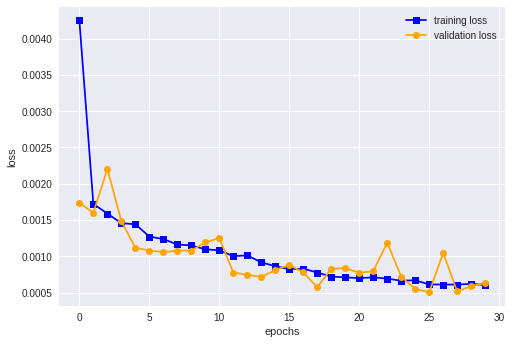

[[72.78700828552246, 0.6454050540924072]] [0.024831705175678922] [635.1799416542053] [0.23457275408131498]


In [0]:
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from sklearn.metrics import classification_report
import time
import matplotlib.pyplot as plt

batchSize=64
kSize=20
poolSize=3

lossVector=[] # gives test RMSE for the CNN
timeVector=[] # gives time taken for training and testing of the CNN respectively
LSloss=[] # gives RMSE for the least squares approach
LStime=[] # gives time taken to execute the least squares approach
classifyH = Sequential()
classifyH.add(Conv1D(32, kernel_size=kSize ,activation='linear',padding='same',input_shape=(100,1)))
classifyH.add(LeakyReLU(alpha=0.1))
classifyH.add(MaxPooling1D(pool_size=poolSize,padding='same'))
classifyH.add(Dropout(0.25))
classifyH.add(Conv1D(64, kSize, activation='linear',padding='same'))
classifyH.add(LeakyReLU(alpha=0.3))
classifyH.add(MaxPooling1D(pool_size=poolSize,padding='same'))
classifyH.add(Dropout(0.25))
classifyH.add(Conv1D(128, kSize, activation='linear',padding='same'))
classifyH.add(LeakyReLU(alpha=0.1))                  
classifyH.add(MaxPooling1D(pool_size=poolSize,padding='same'))
classifyH.add(Dropout(0.4))
classifyH.add(Flatten())
classifyH.add(Dense(128, activation='linear'))
classifyH.add(LeakyReLU(alpha=0.1))           
classifyH.add(Dropout(0.3))
classifyH.add(Dense(1, activation='sigmoid'))
classifyH.compile(loss=keras.losses.mean_squared_error, optimizer='Adam')    
T=time.time()
trainH=classifyH.fit(xTrain,yTrain,batch_size=batchSize,epochs=30,verbose=0,validation_data=(xValid,yValid))
t1=time.time()-T    
T=time.time()
test=classifyH.evaluate(xTest,yTest)
timeVector.append([t1, time.time()-T])
lossVector.append(np.sqrt(test))
loss=trainH.history['loss']
valLoss=trainH.history['val_loss']
epochVec=range(len(loss))
plt.plot(epochVec, loss, color='blue', marker='s', label='training loss')
plt.plot(epochVec, valLoss, color='orange', marker='o', label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)
plt.show()
 
Hvec1=[]
T=time.time()
# for loop below excutes the least squares estimation of H
for I in range(xTest.shape[0]):
    volSeries=xTest[I]
    volSeries=volSeries.reshape(100)
    volSeries=pd.Series(volSeries)
    Hvec1.append(findH(volSeries))
LStime.append(time.time()-T)
LSloss.append(np.sqrt(np.mean(np.power(Hvec1-yTest,2)))) # here we compute the RMSE for the least squares approach  
  
print(timeVector, lossVector, LStime, LSloss) # these values are those found in Table 7

# Robustness Test: fBm with Uniform H

In [0]:


T=1
numStep=100
numPath=5000 #numPaths
np.random.seed(195)
Hs=np.random.uniform(0.0,0.5,5)
Data=pd.DataFrame()

for H in Hs:
    path=fBmPaths(T,numStep, numPath,H)
    dF=pd.DataFrame(path)
    dF['label']=H
    Data=pd.concat([Data,dF])

Data=Data.sample(frac=1) #this randomly re-orders robustData
DataVal=Data.values

from sklearn.model_selection import train_test_split

xValues=DataVal[:,:100]
yValues=DataVal[:,-1]
# split up the data
xTraining, xTest, yTraining, yTest = train_test_split(xValues, yValues , test_size=0.3)
xTrain, xValid, yTrain, yValid = train_test_split(xTraining, yTraining , test_size=0.2)
# reshape
xTrain=xTrain.reshape(xTrain.shape[0], 100,1)
xValid=xValid.reshape(xValid.shape[0], 100,1)
xTest=xTest.reshape(xTest.shape[0], 100,1)
yTrain=yTrain.reshape(yTrain.shape[0], 1)
yValid=yValid.reshape(yValid.shape[0], 1)
yTest=yTest.reshape(yTest.shape[0], 1)

7500/7500 [==============================] - 1s 84us/step


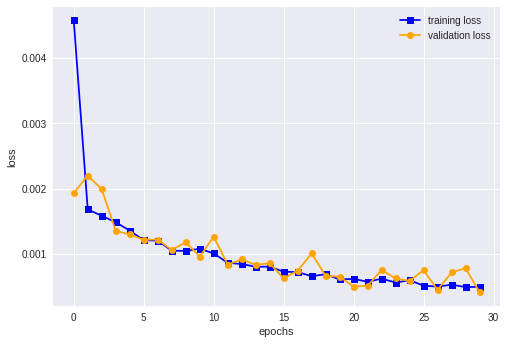

[[71.95200395584106, 0.6345574855804443]] [0.020014504253262542] [615.7362337112427] [0.20896723755265592]


In [0]:
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from sklearn.metrics import classification_report
import time
import matplotlib.pyplot as plt

batchSize=64
kSize=20
poolSize=3

lossVector=[] # gives test RMSE for the CNN
timeVector=[] # gives time taken for training and testing of the CNN respectively
LSloss=[] # gives RMSE for the least squares approach
LStime=[] # gives time taken to execute the least squares approach
classifyH = Sequential()
classifyH.add(Conv1D(32, kernel_size=kSize ,activation='linear',padding='same',input_shape=(100,1)))
classifyH.add(LeakyReLU(alpha=0.1))
classifyH.add(MaxPooling1D(pool_size=poolSize,padding='same'))
classifyH.add(Dropout(0.25))
classifyH.add(Conv1D(64, kSize, activation='linear',padding='same'))
classifyH.add(LeakyReLU(alpha=0.3))
classifyH.add(MaxPooling1D(pool_size=poolSize,padding='same'))
classifyH.add(Dropout(0.25))
classifyH.add(Conv1D(128, kSize, activation='linear',padding='same'))
classifyH.add(LeakyReLU(alpha=0.1))                  
classifyH.add(MaxPooling1D(pool_size=poolSize,padding='same'))
classifyH.add(Dropout(0.4))
classifyH.add(Flatten())
classifyH.add(Dense(128, activation='linear'))
classifyH.add(LeakyReLU(alpha=0.1))           
classifyH.add(Dropout(0.3))
classifyH.add(Dense(1, activation='sigmoid'))
classifyH.compile(loss=keras.losses.mean_squared_error, optimizer='Adam')    
T=time.time()
trainH=classifyH.fit(xTrain,yTrain,batch_size=batchSize,epochs=30,verbose=0,validation_data=(xValid,yValid))
t1=time.time()-T    
T=time.time()
test=classifyH.evaluate(xTest,yTest)
timeVector.append([t1, time.time()-T])
lossVector.append(np.sqrt(test))
loss=trainH.history['loss']
valLoss=trainH.history['val_loss']
epochVec=range(len(loss))
plt.plot(epochVec, loss, color='blue', marker='s', label='training loss')
plt.plot(epochVec, valLoss, color='orange', marker='o', label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)
plt.show()
 
Hvec1=[]
T=time.time()
# for loop below excutes the least squares estimation of H
for I in range(xTest.shape[0]):
    volSeries=xTest[I]
    volSeries=volSeries.reshape(100)
    volSeries=pd.Series(volSeries)
    Hvec1.append(findH(volSeries))
LStime.append(time.time()-T)
LSloss.append(np.sqrt(np.mean(np.power(Hvec1-yTest,2)))) # here we compute the RMSE for the least squares approach  
  
print(timeVector, lossVector, LStime, LSloss) # these values are those found in Table 7 

# Robustness Test: fBm with Beta H

In [0]:
T=1
numStep=100
numPath=5000 #numPaths
np.random.seed(195)
Hs= np.random.beta(1.,9.,5)
Data=pd.DataFrame()

for H in Hs:
    path=fBmPaths(T,numStep, numPath,H)
    dF=pd.DataFrame(path)
    dF['label']=H
    Data=pd.concat([Data,dF])

Data=Data.sample(frac=1) #this randomly re-orders robustData
DataVal=Data.values

from sklearn.model_selection import train_test_split

xValues=DataVal[:,:100]
yValues=DataVal[:,-1]
# split up the data
xTraining, xTest, yTraining, yTest = train_test_split(xValues, yValues , test_size=0.3)
xTrain, xValid, yTrain, yValid = train_test_split(xTraining, yTraining , test_size=0.2)
# reshape
xTrain=xTrain.reshape(xTrain.shape[0], 100,1)
xValid=xValid.reshape(xValid.shape[0], 100,1)
xTest=xTest.reshape(xTest.shape[0], 100,1)
yTrain=yTrain.reshape(yTrain.shape[0], 1)
yValid=yValid.reshape(yValid.shape[0], 1)
yTest=yTest.reshape(yTest.shape[0], 1)

7500/7500 [==============================] - 1s 89us/step


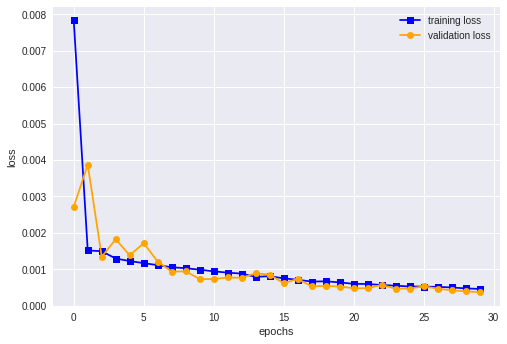

[[72.20021414756775, 0.6653406620025635]] [0.019447227392371064] [622.3574440479279] [0.09784736971488514]


In [0]:
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from sklearn.metrics import classification_report
import time
import matplotlib.pyplot as plt

batchSize=64
kSize=20
poolSize=3

lossVector=[] # gives test RMSE for the CNN
timeVector=[] # gives time taken for training and testing of the CNN respectively
LSloss=[] # gives RMSE for the least squares approach
LStime=[] # gives time taken to execute the least squares approach
classifyH = Sequential()
classifyH.add(Conv1D(32, kernel_size=kSize ,activation='linear',padding='same',input_shape=(100,1)))
classifyH.add(LeakyReLU(alpha=0.1))
classifyH.add(MaxPooling1D(pool_size=poolSize,padding='same'))
classifyH.add(Dropout(0.25))
classifyH.add(Conv1D(64, kSize, activation='linear',padding='same'))
classifyH.add(LeakyReLU(alpha=0.3))
classifyH.add(MaxPooling1D(pool_size=poolSize,padding='same'))
classifyH.add(Dropout(0.25))
classifyH.add(Conv1D(128, kSize, activation='linear',padding='same'))
classifyH.add(LeakyReLU(alpha=0.1))                  
classifyH.add(MaxPooling1D(pool_size=poolSize,padding='same'))
classifyH.add(Dropout(0.4))
classifyH.add(Flatten())
classifyH.add(Dense(128, activation='linear'))
classifyH.add(LeakyReLU(alpha=0.1))           
classifyH.add(Dropout(0.3))
classifyH.add(Dense(1, activation='sigmoid'))
classifyH.compile(loss=keras.losses.mean_squared_error, optimizer='Adam')    
T=time.time()
trainH=classifyH.fit(xTrain,yTrain,batch_size=batchSize,epochs=30,verbose=0,validation_data=(xValid,yValid))
t1=time.time()-T    
T=time.time()
test=classifyH.evaluate(xTest,yTest)
timeVector.append([t1, time.time()-T])
lossVector.append(np.sqrt(test))
loss=trainH.history['loss']
valLoss=trainH.history['val_loss']
epochVec=range(len(loss))
plt.plot(epochVec, loss, color='blue', marker='s', label='training loss')
plt.plot(epochVec, valLoss, color='orange', marker='o', label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)
plt.show()
 
Hvec1=[]
T=time.time()
# for loop below excutes the least squares estimation of H
for I in range(xTest.shape[0]):
    volSeries=xTest[I]
    volSeries=volSeries.reshape(100)
    volSeries=pd.Series(volSeries)
    Hvec1.append(findH(volSeries))
LStime.append(time.time()-T)
LSloss.append(np.sqrt(np.mean(np.power(Hvec1-yTest,2)))) # here we compute the RMSE for the least squares approach  
  
print(timeVector, lossVector, LStime, LSloss) # these values are those found in Table 7 

# Robustness Test: random $\eta$ and $H$

In [0]:
numPaths=25000
path=randomisedPaths(numPaths)
Data=pd.DataFrame()

for i in range(numPaths):
    dF=pd.DataFrame(path[0][i].reshape(1,100))
    dF['label']=path[1][i]
    Data=pd.concat([Data,dF])

Data=Data.sample(frac=1) 
DataVal=Data.values

from sklearn.model_selection import train_test_split

xValues=DataVal[:,:100]
yValues=DataVal[:,-1]
# split up the data
xTraining, xTest, yTraining, yTest = train_test_split(xValues, yValues , test_size=0.3)
xTrain, xValid, yTrain, yValid = train_test_split(xTraining, yTraining , test_size=0.2)
# reshape
xTrain=xTrain.reshape(xTrain.shape[0], 100,1)
xValid=xValid.reshape(xValid.shape[0], 100,1)
xTest=xTest.reshape(xTest.shape[0], 100,1)
yTrain=yTrain.reshape(yTrain.shape[0], 1)
yValid=yValid.reshape(yValid.shape[0], 1)
yTest=yTest.reshape(yTest.shape[0], 1)

7500/7500 [==============================] - 1s 81us/step


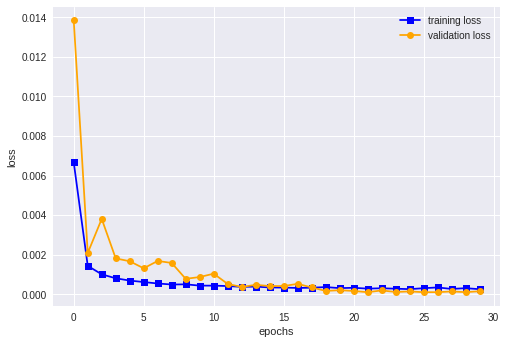

[[66.51939702033997, 0.6056950092315674]] [0.013828618435852938] [598.511351108551] [0.14987541808144983]


In [0]:
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from sklearn.metrics import classification_report
import time

batchSize=64
kSize=20
poolSize=3

lossVector=[] # gives test RMSE for the CNN
timeVector=[] # gives time taken for training and testing of the CNN respectively
LSloss=[] # gives RMSE for the least squares approach
LStime=[] # gives time taken to execute the least squares approach
classifyH = Sequential()
classifyH.add(Conv1D(32, kernel_size=kSize ,activation='linear',padding='same',input_shape=(100,1)))
classifyH.add(LeakyReLU(alpha=0.1))
classifyH.add(MaxPooling1D(pool_size=poolSize,padding='same'))
classifyH.add(Dropout(0.25))
classifyH.add(Conv1D(64, kSize, activation='linear',padding='same'))
classifyH.add(LeakyReLU(alpha=0.3))
classifyH.add(MaxPooling1D(pool_size=poolSize,padding='same'))
classifyH.add(Dropout(0.25))
classifyH.add(Conv1D(128, kSize, activation='linear',padding='same'))
classifyH.add(LeakyReLU(alpha=0.1))                  
classifyH.add(MaxPooling1D(pool_size=poolSize,padding='same'))
classifyH.add(Dropout(0.4))
classifyH.add(Flatten())
classifyH.add(Dense(128, activation='linear'))
classifyH.add(LeakyReLU(alpha=0.1))           
classifyH.add(Dropout(0.3))
classifyH.add(Dense(1, activation='sigmoid'))
classifyH.compile(loss=keras.losses.mean_squared_error, optimizer='Adam')    
T=time.time()
trainH=classifyH.fit(xTrain,yTrain,batch_size=batchSize,epochs=30,verbose=0,validation_data=(xValid,yValid))
t1=time.time()-T    
T=time.time()
test=classifyH.evaluate(xTest,yTest)
timeVector.append([t1, time.time()-T])
lossVector.append(np.sqrt(test))
loss=trainH.history['loss']
valLoss=trainH.history['val_loss']
epochVec=range(len(loss))
plt.plot(epochVec, loss, color='blue', marker='s', label='training loss')
plt.plot(epochVec, valLoss, color='orange', marker='o', label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)
plt.show()

Hvec1=[]
T=time.time()
# for loop below excutes the least squares estimation of H
for I in range(xTest.shape[0]):
    volSeries=xTest[I]
    volSeries=volSeries.reshape(100)
    volSeries=pd.Series(volSeries)
    Hvec1.append(findH(volSeries))
LStime.append(time.time()-T)
LSloss.append(np.sqrt(np.mean(np.power(Hvec1-yTest,2)))) # here we compute the RMSE for the least squares approach  
  
print(timeVector, lossVector, LStime, LSloss) # these values are those found in Table 6 

   




# Learning $\eta$ and $H$

In [0]:
numPaths=25000
path=randomisedPaths(numPaths)
Data=pd.DataFrame()

for i in range(numPaths):
    dF=pd.DataFrame(path[0][i].reshape(1,100))
    dF['H']=path[1][i]
    dF['eta']=path[2][i]
    Data=pd.concat([Data,dF])

Data=Data.sample(frac=1) 
DataVal=Data.values

from sklearn.model_selection import train_test_split

xValues=DataVal[:,:100]
yValues=DataVal[:,-2:]
# split up the data
xTraining, xTest, yTraining, yTest = train_test_split(xValues, yValues , test_size=0.3)
xTrain, xValid, yTrain, yValid = train_test_split(xTraining, yTraining , test_size=0.2)
# reshape
xTrain=xTrain.reshape(xTrain.shape[0], 100,1)
xValid=xValid.reshape(xValid.shape[0], 100,1)
xTest=xTest.reshape(xTest.shape[0], 100,1)
yTrain=yTrain.reshape(yTrain.shape[0], 2)
yValid=yValid.reshape(yValid.shape[0], 2)
yTest=yTest.reshape(yTest.shape[0], 2)

7500/7500 [==============================] - 1s 82us/step


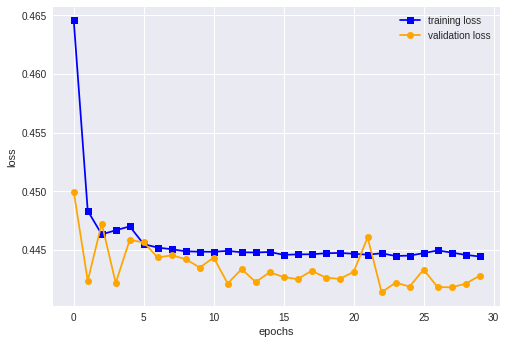

[[71.81764101982117, 0.6171047687530518]] [0.6663200981141789] [613.6234173774719] [1.169755359555449]


In [0]:
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from sklearn.metrics import classification_report
import time
import matplotlib.pyplot as plt

batchSize=64
kSize=20
poolSize=3

lossVector=[]
timeVector=[]
LSloss=[]
LStime=[]
classifyH = Sequential()
classifyH.add(Conv1D(32, kernel_size=kSize ,activation='linear',padding='same',input_shape=(100,1)))
classifyH.add(LeakyReLU(alpha=0.1))
classifyH.add(MaxPooling1D(pool_size=poolSize,padding='same'))
classifyH.add(Dropout(0.25))
classifyH.add(Conv1D(64, kSize, activation='linear',padding='same'))
classifyH.add(LeakyReLU(alpha=0.3))
classifyH.add(MaxPooling1D(pool_size=poolSize,padding='same'))
classifyH.add(Dropout(0.25))
classifyH.add(Conv1D(128, kSize, activation='linear',padding='same'))
classifyH.add(LeakyReLU(alpha=0.1))                  
classifyH.add(MaxPooling1D(pool_size=poolSize,padding='same'))
classifyH.add(Dropout(0.4))
classifyH.add(Flatten())
classifyH.add(Dense(128, activation='linear'))
classifyH.add(LeakyReLU(alpha=0.1))           
classifyH.add(Dropout(0.3))
classifyH.add(Dense(2, activation='sigmoid'))
classifyH.compile(loss=keras.losses.mean_squared_error, optimizer='Adam')    
T=time.time()
trainH=classifyH.fit(xTrain,yTrain,batch_size=batchSize,epochs=30,verbose=0,validation_data=(xValid,yValid))
t1=time.time()-T    
T=time.time()
testH=classifyH.evaluate(xTest,yTest)
timeVector.append([t1, time.time()-T])
lossVector.append(np.sqrt(testH))
loss=trainH.history['loss']
valLoss=trainH.history['val_loss']
epochVec=range(len(loss))
plt.plot(epochVec, loss, color='blue', marker='s', label='training loss')
plt.plot(epochVec, valLoss, color='orange', marker='o', label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)
plt.show()
 

Hvec1=[]
etaVec=[]
T=time.time()
# for loop below excutes the least squares estimation of H and eta
for I in range(xTest.shape[0]):
    volSeries=xTest[I]
    volSeries=volSeries.reshape(100)
    volSeries=pd.Series(volSeries)
    K_q=[]
    qVec=[.5, 1., 1.5, 2., 3.]
    logVec=np.log(range(1,31))
    for q in qVec:
        meanVec=[]
        for n in range(1,31):
            vn=lagged_mean(volSeries,q,n)
            meanVec.append(vn)
        meanlogVec=np.log(meanVec)
        res=np.polyfit(logVec,meanlogVec,1)
        K_q.append(res[0])
    res=np.polyfit(qVec,K_q,1)
    Hvec1.append(res[0])
    etaVec.append(res[1])
LStime.append(time.time()-T)
errVec=[np.asarray(Hvec1).reshape(7500,1),np.asarray(etaVec).reshape(7500,1)]-yTest # here we compute the RMSE for the least squares approach  
LSloss.append(np.sqrt(np.mean(np.power(errVec,2))))

print(timeVector, lossVector, LStime, LSloss ) # these values are those found in Table 8